In [1]:
import artm
import numpy as np
import pandas as pd
import os
import io
import glob
from matplotlib import pyplot as plt
import pickle

In [2]:
!head -3 /mnt/data/files/datasets/arxiv_abstract_stem.vw

0704.0001 |title calcul of prompt diphoton product cross section at tevatron and lhc energi |abstract fulli differenti calcul perturb quantum chromodynam present product massiv photon pair hadron collid next-to-lead order perturb contribut quark-antiquark gluon- anti quark gluon-gluon subprocess includ well all-ord resumm initial-st gluon radiat valid next-to-next-to-lead logarithm accuraci region phase space specifi calcul reliabl good agreement demonstr data fermilab tevatron predict made detail test cdf data predict shown distribut diphoton pair produc energi larg hadron collid lhc distribut diphoton pair decay higg boson contrast produc qcd process lhc show enhanc sensit signal obtain judici select event |categories hep-ph
0704.0002 |title sparsity-certifi graph decomposit |abstract describ new algorithm k ell -pebbl game color use obtain character famili k ell -spars graph algorithm solut famili problem concern tree decomposit graph special instanc spars graph appear rigid theori 

In [3]:
source_file = '/mnt/data/files/datasets/arxiv_abstract_stem.vw'
batches_folder = "batches"
if not glob.glob(os.path.join(batches_folder, "*")):
    batch_vectorizer = artm.BatchVectorizer(data_path=source_file, data_format="vowpal_wabbit", 
                                            target_folder=batches_folder, batch_size=500)
else:
    batch_vectorizer = artm.BatchVectorizer(data_path=batches_folder,
                                            data_format='batches')

In [4]:
dict_name = os.path.join(batches_folder, "dictionary.dict")
dictionary = artm.Dictionary()
if not os.path.exists(dict_name):
    dictionary.gather(batches_folder)
    dictionary.filter(class_id='title', min_df=3, max_df=100000)
    dictionary.filter(class_id='abstract', min_df=3, max_df=100000)
    dictionary.save(dict_name)
else:
    dictionary.load(dict_name)

In [5]:
scores_list = [
    artm.PerplexityScore(name='PerplexityScoreTitle', class_ids=['title']),
    artm.PerplexityScore(name='PerplexityScoreAbstr', class_ids=['abstract']),
    artm.PerplexityScore(name='PerplexityScoreCtg', class_ids=['categories']),
    artm.SparsityThetaScore(name='SpTheta', eps=1e-6),
    artm.SparsityPhiScore(name='SpPhiTitle', class_id='title', eps=1e-6), 
    artm.SparsityPhiScore(name='SpPhiAbstr', class_id='abstract', eps=1e-6),
    artm.SparsityPhiScore(name='SpPhiCtg', class_id='categories', eps=0.01),
    artm.TopTokensScore(name="title_top_words", num_tokens=30, class_id="title"),
    artm.TopTokensScore(name="abstract_top_words", num_tokens=30, class_id="abstract"),
    artm.TopTokensScore(name="categories_top_words", num_tokens=10, class_id='categories')
]

decorr_t = artm.DecorrelatorPhiRegularizer(tau=0, class_ids=['title','abstract'], name='decorr_t')
decorr_c = artm.DecorrelatorPhiRegularizer(tau=0, class_ids=['categories'], name='decorr_c')

theta = artm.SmoothSparseThetaRegularizer(tau=0, name='spth')
phi = artm.SmoothSparsePhiRegularizer(tau=0, name="sph")
sparse_phi = artm.SmoothSparsePhiRegularizer(tau=0, name="sprsph")

hier = artm.hARTM(class_ids={"title":10, "abstract":1, "categories":20},   
                  cache_theta=True,
                  reuse_theta=True,  
                  seed=789, 
                  scores=scores_list,
                  regularizers = [decorr_t, decorr_c, phi])

%time level0 = hier.add_level(num_topics=8)
%time level0.initialize(dictionary)

CPU times: user 1.67 ms, sys: 3.06 ms, total: 4.73 ms
Wall time: 3.97 ms
CPU times: user 2.85 s, sys: 92.6 ms, total: 2.94 s
Wall time: 2.48 s


In [6]:
level0.regularizers['decorr_t'].tau = 1000
level0.regularizers['decorr_c'].tau = 700
level0.regularizers['sph'].tau = 0.15

%time level0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 49min 55s, sys: 17.4 s, total: 50min 12s
Wall time: 14min 55s


In [7]:
import datetime

class ARTMAnalyzer():

    def __init__(self, model):
        self.model = model
        self.result_tracker = {}
    
    def log_results(self):
        
        print(self.model.regularizers["spth"])
        
        now = datetime.datetime.now()
        
        with open("ARTM_MODELS_STAT.txt", "a") as log_file:
            log_file.write("===============================\n")
            log_file.write(str(now))
            log_file.write("\n")
            
            log_file.write("Num_topics: {}".format(self.model.num_topics))
            
            log_file.write("Regulizers:\n")
            for reg in self.model.regularizers.data.keys():
                reg_info = self.model.regularizers[reg]
                print(reg_info)
                log_file.write("{}:: gamma: {}, tau: {}\n".format(reg, reg_info.gamma, reg_info.tau))
                
            log_file.write("Modalities:\n")
            for cl in self.model.class_ids.keys():
                cl_info = self.model.class_ids[cl]
                log_file.write("{}:: coef: {}\n".format(cl, cl_info))
    
            log_file.write("Scores:\n")
            for score in self.model.score_tracker.keys():
                if "word" in score:
                    continue
                score_info = self.model.score_tracker[score]
                log_file.write("{}:: result: {}\n".format(score, score_info.value[-1]))
    
        
    def check_theta(self):
        pass
    
    def num_documents(self, filename):
        with io.open(filename, 'r', encoding='utf-8') as f:
            s = f.read()
            t = s.split('\n')
            return len(t) - 1
    
    def get_nd(self, vw_path, destination):
        data = ""
        with open(vw_path, "r") as f:
            data = f.readlines()
            
        nd = {}
        for doc in data:
            name = doc.split(" ")[0]
            cur_nd = 0
            for term in doc.split(" "):
                if ("|" in term) or ("_" in term) or (":" not in term):
                    continue
                cur_nd += int(term.split(":")[-1])
            nd[name] = cur_nd
        with open(destination, "wb") as d:
            pickle.dump(nd, d)
    
    def visualize_scores(self):

        scores_list = self.model.score_tracker
        
        num_not_tokens_scores = 0
        for score in scores_list.keys():
            if "word" not in score:
                num_not_tokens_scores += 1
        
        num_scores = num_not_tokens_scores
        n = int(round(num_scores / 3)) + 1
        fig, axs = plt.subplots(n, 3, figsize=(15, 25))

        i = 0
        for score_name in scores_list.keys():
    
            if "word" in score_name:
                continue
            
            score = scores_list[score_name]

            j, k = i // 3, i % 3

            axs[j, k].plot(score.value[1:])
            axs[j, k].set_title("Score: {}; Result: {}".format(score_name, round(score.last_value, 3)))
            axs[j, k].grid()
            
            i += 1

        plt.show()
        
    def topics(self):
        for topic_name in self.model.topic_names:
            print(topic_name + ': ',)
            try:
                print(", ".join(self.model.score_tracker['title_top_words'].last_tokens[topic_name]))
            except:
                print()
                print("Not enough title words in a topic")
            try:
                print(", ".join(self.model.score_tracker['abstract_top_words'].last_tokens[topic_name]))
            except:
                print()
                print("Not enough abstract words in a topic")
            try:
                print(", ".join(self.model.score_tracker['categories_top_words'].last_tokens[topic_name]))
            except:
                print()
                print("Not enough categories in a topic")
            print() 
            print()
            
    def save_theta(self, path):
        theta = self.model.get_theta()
        theta.to_csv(path, sep=";", encoding="utf-8")
        
    def save_phi(self, path):
        phi = self.model.get_phi()
        phi.to_csv(path, sep=";", encoding="utf-8")
        
    def save_model(self, path):
        self.model.dump_artm_model(path)

In [13]:
def get_nd(vw_path):
    data = ""
    with open(vw_path, "r") as f:
        data = f.readlines()

    nd = {}
    for i, doc in enumerate(data):
        name = doc.split(" ")[0]
        nd[name] = i
    return nd

In [8]:
analyzer0 = ARTMAnalyzer(level0)

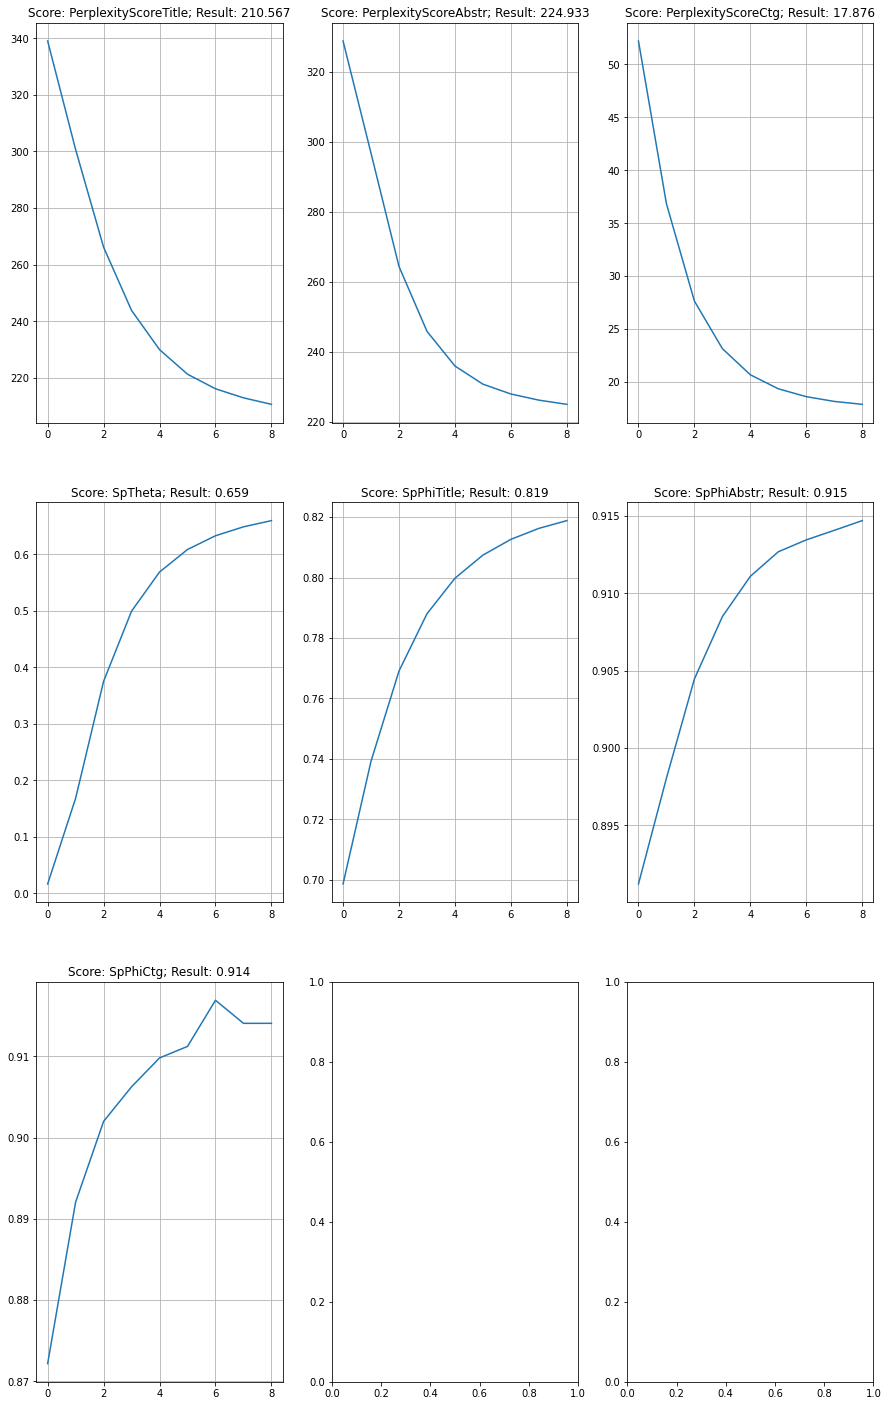

In [9]:
analyzer0.visualize_scores()

In [10]:
analyzer0.topics()

topic_0: 
quantum, by, optic, state, system, use, entangl, an, measur, comput, atom, dynam, photon, coher, simul, generat, laser, mechan, process, from, control, light, time, reson, singl, beam, base, frequenc, nonlinear, analysi
optic, entangl, atom, photon, design, frequenc, control, effici, coher, beam, laser, light, classic, puls, singl, implement, nois, reson, particl, qubit, scheme, cell, mode, devic, caviti, achiev, power, nonlinear, test, wave
quant-ph, physics.optics, cond-mat.dis-nn, physics.comp-ph, physics.atom-ph, physics.ins-det, physics.bio-ph, physics.data-an, nlin.PS, cs.SE


topic_1: 
group, graph, space, complex, problem, flow, surfac, finit, number, manifold, algebra, curv, method, theorem, an, general, structur, geometri, complet, set, local, bound, invari, point, theori, metric, over, project, order, varieti
g, graph, k, x, p, algebra, r, c, surfac, defin, manifold, flow, f, h, theorem, connect, mathcal, mathbb, curv, conjectur, dimens, map, complet, let, v, proof

In [24]:
analyzer0.save_model('model')
analyzer0.save_phi('phi0.csv')
analyzer0.save_theta('theta0.csv')

In [14]:
nd = get_nd(source_file)

In [15]:
theta = level0.get_theta()

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
theta_dict = {doc_id: np.array(theta[nd[doc_id]]) for doc_id in list(nd.keys())[:-1]}

In [20]:
cosine_similarity(np.array([theta_dict['1806.03822']]), np.array([theta_dict['1606.05250']]))[0][0]

1.0

In [21]:
cosine_similarity(np.array([theta_dict['1810.04805']]), np.array([theta_dict['1906.02715']]))[0][0]

0.9945168

In [22]:
cosine_similarity(np.array([theta_dict['1810.04805']]), np.array([theta_dict['1806.03822']]))[0][0]

1.0

In [23]:
cosine_similarity(np.array([theta_dict['1810.04805']]), np.array([theta_dict['0704.0001']]))[0][0]

0.0